Import Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.figsize'] = (10, 5)


Load Datasets

In [27]:
sentiment_df = pd.read_csv("fear_greed_index.csv")
trades_df = pd.read_csv("historical_data.csv")

print(sentiment_df.head())
print(trades_df.head())


    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50 

Clean and Format Data

In [28]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')
sentiment_df = sentiment_df[['date', 'value', 'classification','timestamp']]
sentiment_df.rename(columns={'value': 'sentiment_value',
                             'classification': 'sentiment_label'}, inplace=True)

# Convert timestamp column to datetime (IST format to datetime)
trades_df['Timestamp IST'] = pd.to_datetime(trades_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')

trades_df['trade_date'] = trades_df['Timestamp IST'].dt.date

trades_df = trades_df[['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD',
                       'Side', 'Closed PnL', 'Fee', 'trade_date']]

trades_df.rename(columns={
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_token',
    'Size USD': 'size_usd',
    'Closed PnL': 'pnl'
}, inplace=True)

print("\n Cleaned Sentiment Data:")
print(sentiment_df.head())

print("\n Cleaned Trades Data:")
print(trades_df.head())




 Cleaned Sentiment Data:
        date  sentiment_value sentiment_label   timestamp
0 2018-02-01               30            Fear  1517463000
1 2018-02-02               15    Extreme Fear  1517549400
2 2018-02-03               40            Fear  1517635800
3 2018-02-04               24    Extreme Fear  1517722200
4 2018-02-05               11    Extreme Fear  1517808600

 Cleaned Trades Data:
                                      Account  Coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size_token  size_usd Side  pnl       Fee  trade_date  
0      986.87   7872.16  BUY  0.0  0.345404  2024-12-02  
1       16.00    127.68  BUY  0.0  0.005600  2024-12-0

Convert Timestamp to Date and Merge Datasets

In [29]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['timestamp'], unit='s')

sentiment_df['date'] = sentiment_df['date'].dt.date

trades_df['trade_date'] = pd.to_datetime(trades_df['trade_date']).dt.date

merged_df = pd.merge(
    trades_df,
    sentiment_df[['date', 'sentiment_value', 'sentiment_label']],
    left_on='trade_date',
    right_on='date',
    how='left'
)

merged_df.drop(columns=['date'], inplace=True)

print("\n Merged Data Preview:")
print(merged_df.head())

print("\n Missing sentiment_label rows:", merged_df['sentiment_label'].isna().sum())
print("Total merged rows:", len(merged_df))



 Merged Data Preview:
                                      Account  Coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size_token  size_usd Side  pnl       Fee  trade_date  sentiment_value  \
0      986.87   7872.16  BUY  0.0  0.345404  2024-12-02             80.0   
1       16.00    127.68  BUY  0.0  0.005600  2024-12-02             80.0   
2      144.09   1150.63  BUY  0.0  0.050431  2024-12-02             80.0   
3      142.98   1142.04  BUY  0.0  0.050043  2024-12-02             80.0   
4        8.73     69.75  BUY  0.0  0.003055  2024-12-02             80.0   

  sentiment_label  
0   Extreme Greed  
1   Extreme Greed  
2   Extreme Greed  
3   Ext

Descriptive & Statistical Analysis

In [31]:
print(" Merged Data Summary:")
print(merged_df.info())
print("\nBasic Statistics:")
print(merged_df.describe())

print("\nTrades by Sentiment:")
sentiment_counts = merged_df['sentiment_label'].value_counts()
print(sentiment_counts)

avg_pnl_by_sentiment = merged_df.groupby('sentiment_label')['pnl'].mean().sort_values(ascending=False)
print("\nAverage PnL by Market Sentiment:")
print(avg_pnl_by_sentiment)

median_pnl_by_sentiment = merged_df.groupby('sentiment_label')['pnl'].median().sort_values(ascending=False)
print("\nMedian PnL by Market Sentiment:")
print(median_pnl_by_sentiment)

volume_by_sentiment = merged_df.groupby('sentiment_label')['size_usd'].sum().sort_values(ascending=False)
print("\nTotal Traded Volume (USD) by Market Sentiment:")
print(volume_by_sentiment)

# Win rate = fraction of trades with positive PnL
win_rate = merged_df.groupby('sentiment_label')['pnl'].apply(lambda x: (x > 0).mean() * 100).sort_values(ascending=False)
print("\nWin Rate by Market Sentiment (% of profitable trades):")
print(win_rate)

summary = pd.DataFrame({
    'Avg_PnL': avg_pnl_by_sentiment,
    'Median_PnL': median_pnl_by_sentiment,
    'Total_Volume_USD': volume_by_sentiment,
    'Win_Rate(%)': win_rate
}).sort_values(by='Avg_PnL', ascending=False)

print("\n Sentiment Performance Summary:")
print(summary)


 Merged Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Account          211224 non-null  object 
 1   Coin             211224 non-null  object 
 2   execution_price  211224 non-null  float64
 3   size_token       211224 non-null  float64
 4   size_usd         211224 non-null  float64
 5   Side             211224 non-null  object 
 6   pnl              211224 non-null  float64
 7   Fee              211224 non-null  float64
 8   trade_date       211224 non-null  object 
 9   sentiment_value  211218 non-null  float64
 10  sentiment_label  211218 non-null  object 
dtypes: float64(6), object(5)
memory usage: 17.7+ MB
None

Basic Statistics:
       execution_price    size_token      size_usd            pnl  \
count    211224.000000  2.112240e+05  2.112240e+05  211224.000000   
mean      11414.723350  4.623365e+03  5.6

Visual Analysis

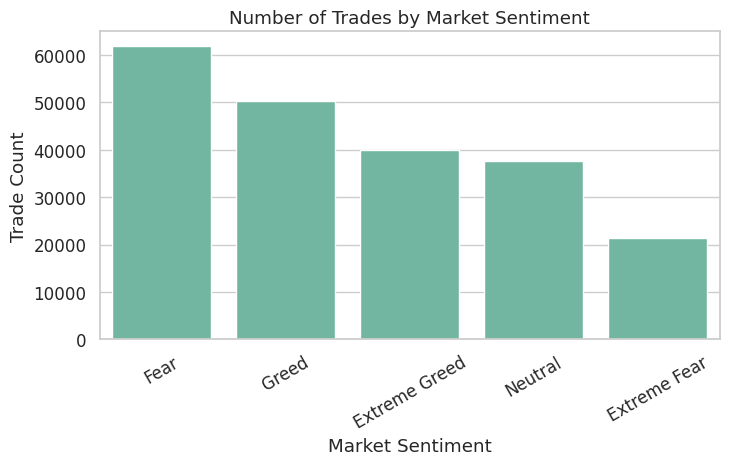

/tmp/ipython-input-2186618346.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_pnl, x='sentiment_label', y='pnl', palette='coolwarm')


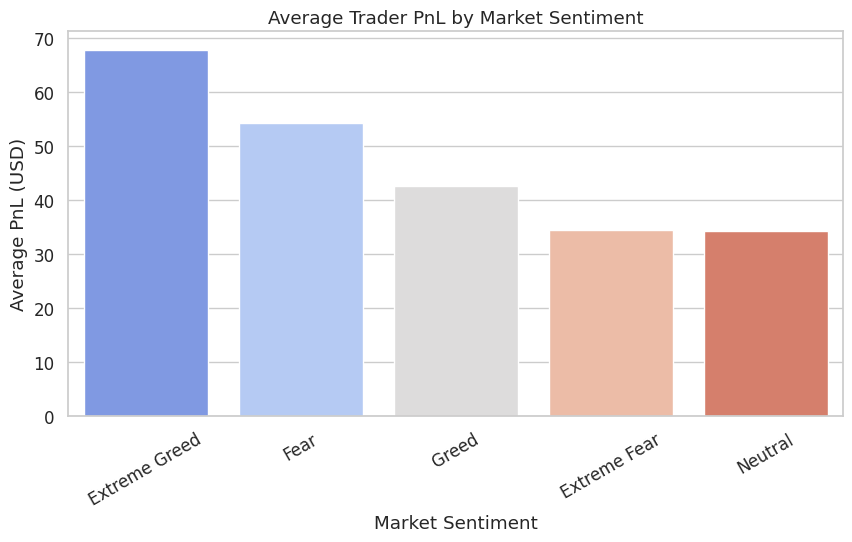

/tmp/ipython-input-2186618346.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='sentiment_label', y='pnl', palette='Spectral')


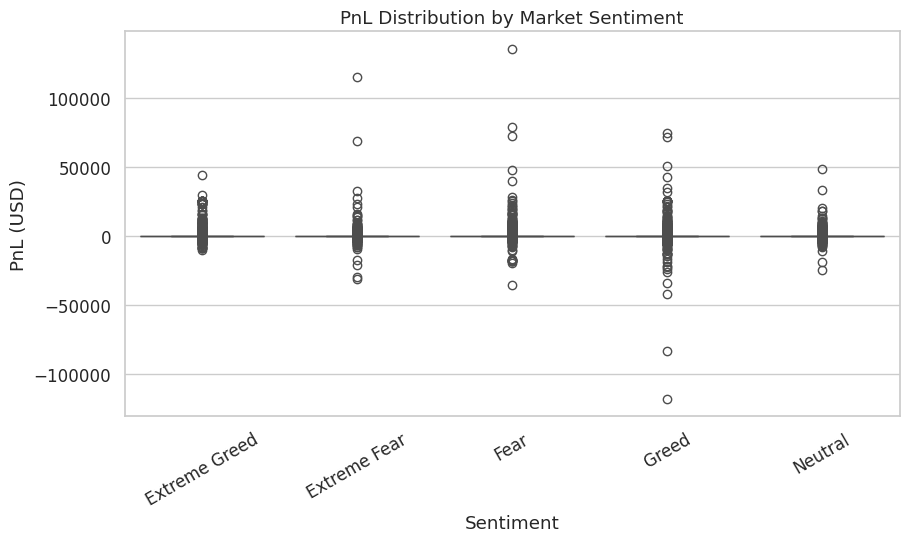

/tmp/ipython-input-2186618346.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=volume_by_sentiment, x='sentiment_label', y='size_usd', palette='viridis')


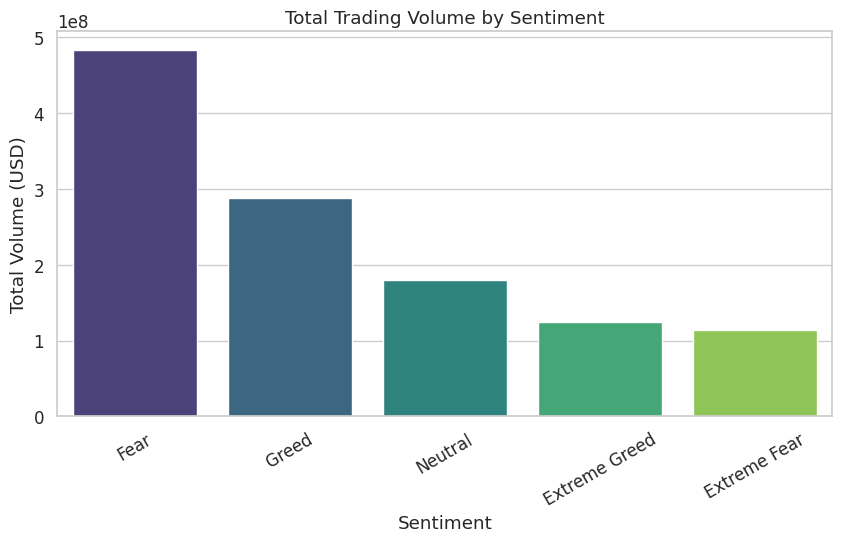

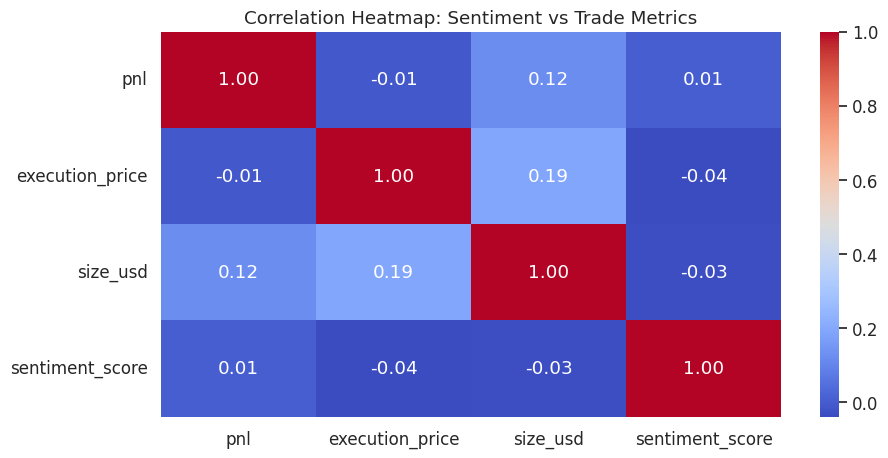

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='Set2', font_scale=1.1)
plt.rcParams['figure.figsize'] = (10, 5)

plt.figure(figsize=(8,4))
sns.countplot(data=merged_df, x='sentiment_label', order=merged_df['sentiment_label'].value_counts().index)
plt.title("Number of Trades by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Trade Count")
plt.xticks(rotation=30)
plt.show()

avg_pnl = merged_df.groupby('sentiment_label')['pnl'].mean().sort_values(ascending=False).reset_index()
sns.barplot(data=avg_pnl, x='sentiment_label', y='pnl', palette='coolwarm')
plt.title("Average Trader PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL (USD)")
plt.xticks(rotation=30)
plt.show()

sns.boxplot(data=merged_df, x='sentiment_label', y='pnl', palette='Spectral')
plt.title("PnL Distribution by Market Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("PnL (USD)")
plt.xticks(rotation=30)
plt.show()

volume_by_sentiment = merged_df.groupby('sentiment_label')['size_usd'].sum().sort_values(ascending=False).reset_index()
sns.barplot(data=volume_by_sentiment, x='sentiment_label', y='size_usd', palette='viridis')
plt.title("Total Trading Volume by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Total Volume (USD)")
plt.xticks(rotation=30)
plt.show()

sentiment_map = {
    'Extreme Fear': 0, 'Fear': 25, 'Neutral': 50, 'Greed': 75, 'Extreme Greed': 100
}
merged_df['sentiment_score'] = merged_df['sentiment_label'].map(sentiment_map)

corr = merged_df[['pnl', 'execution_price', 'size_usd', 'sentiment_score']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap: Sentiment vs Trade Metrics")
plt.show()


Insight Summary & Interpretation

In [35]:
avg_pnl_by_sentiment = merged_df.groupby('sentiment_label')['pnl'].mean().sort_values(ascending=False)
median_pnl_by_sentiment = merged_df.groupby('sentiment_label')['pnl'].median().sort_values(ascending=False)
win_rate_by_sentiment = merged_df.groupby('sentiment_label')['pnl'].apply(lambda x: (x > 0).mean() * 100)

volume_by_sentiment = merged_df.groupby('sentiment_label')['size_usd'].sum().sort_values(ascending=False)

print("INSIGHT SUMMARY")

print(f"Highest *average* PnL observed during: {avg_pnl_by_sentiment.idxmax()} ({avg_pnl_by_sentiment.max():.4f} USD)")
print(f"Lowest *average* PnL observed during: {avg_pnl_by_sentiment.idxmin()} ({avg_pnl_by_sentiment.min():.4f} USD)")
print(f"Median PnL peaks during: {median_pnl_by_sentiment.idxmax()} ({median_pnl_by_sentiment.max():.4f} USD)")
print(f"Highest win rate: {win_rate_by_sentiment.idxmax()} ({win_rate_by_sentiment.max():.2f}%)")
print(f"Maximum trading volume (USD): {volume_by_sentiment.idxmax()} ({volume_by_sentiment.max():,.0f})")

correlation = merged_df[['pnl', 'execution_price', 'size_usd', 'sentiment_score']].corr()['pnl']
print("\n Correlation with PnL:")
print(correlation)

print("\n INTERPRETATION:")
print(f"- Traders tend to perform better during **{avg_pnl_by_sentiment.idxmax()}** markets.")
print(f"- Trading activity (volume) is highest when sentiment is **{volume_by_sentiment.idxmax()}**, suggesting more aggressive trading in that phase.")
print(f"- Win rate trends indicate traders make profitable trades {win_rate_by_sentiment.max():.1f}% of the time under {win_rate_by_sentiment.idxmax()} conditions.")
print("- Correlation matrix shows how sentiment relates to profitability and trade characteristics — e.g., if sentiment_score is positively correlated with PnL, traders benefit from bullish sentiment.")
print("- These insights can help design smarter trading strategies — for example, reducing leverage or exposure during fear-driven markets.")


INSIGHT SUMMARY
Highest *average* PnL observed during: Extreme Greed (67.8929 USD)
Lowest *average* PnL observed during: Neutral (34.3077 USD)
Median PnL peaks during: Extreme Fear (0.0000 USD)
Highest win rate: Extreme Greed (46.49%)
Maximum trading volume (USD): Fear (483,324,790)

 Correlation with PnL:
pnl                1.000000
execution_price   -0.006505
size_usd           0.123589
sentiment_score    0.005970
Name: pnl, dtype: float64

 INTERPRETATION:
- Traders tend to perform better during **Extreme Greed** markets.
- Trading activity (volume) is highest when sentiment is **Fear**, suggesting more aggressive trading in that phase.
- Win rate trends indicate traders make profitable trades 46.5% of the time under Extreme Greed conditions.
- Correlation matrix shows how sentiment relates to profitability and trade characteristics — e.g., if sentiment_score is positively correlated with PnL, traders benefit from bullish sentiment.
- These insights can help design smarter trading s